In [1]:
import pandas
import scipy.stats

import hetio.hetnet
import hetio.readwrite
import hetio.stats

from utils import rawgit, open_gz_url, obo_iri

## Define the metagraph and instantiate the graph

In [2]:
kind_to_abbev = {
    
    # metanodes
    'compound': 'C',
    'disease': 'D',
    'gene': 'G',
    'anatomy': 'A',
    'symptom': 'S',
    'side effect': 'SE',
    'pathway': 'PW',
    'perturbation': 'PB',
    'biological process': 'BP',
    'cellular component': 'CC',
    'molecular function': 'MF',
    
    # metaedges
    'indication': 'i',
    'target': 't',
    'binding': 'b',
    'expression': 'e',
    'regulation': 'r',
    'upregulation': 'u',
    'downregulation': 'd',
    'interaction': 'i',
    'evolution': 'e',
    'knockdown downregulation': 'kd',
    'knockdown upregulation': 'ku',
    'overexpression downregulation': 'od',
    'overexpression upregulation': 'up',
    'participation': 'p',
    'similarity': 's',
    'association': 'a',
    'variation': 'v',
    'function': 'f',
    'localization': 'l',
    'presense': 'p',
    'causation': 'c',
}

metaedge_tuples = [
    ('compound', 'disease', 'indication', 'both'),
    ('compound', 'gene', 'target', 'both'),
    ('compound', 'gene', 'binding', 'both'),
    ('compound', 'gene', 'upregulation', 'both'),
    ('compound', 'gene', 'downregulation', 'both'),
    ('compound', 'compound', 'similarity', 'both'),
    ('compound', 'side effect', 'causation', 'both'),
    ('gene', 'anatomy', 'expression', 'both'),
    ('gene', 'anatomy', 'upregulation', 'both'),
    ('gene', 'anatomy', 'downregulation', 'both'),
    ('gene', 'gene', 'interaction', 'both'),
    ('gene', 'gene', 'evolution', 'both'),
    ('gene', 'gene', 'knockdown downregulation', 'forward'),
    ('gene', 'gene', 'knockdown upregulation', 'forward'),
    ('gene', 'gene', 'overexpression downregulation', 'forward'),
    ('gene', 'gene', 'overexpression upregulation', 'forward'),
    ('gene', 'pathway', 'participation', 'both'),
    ('gene', 'perturbation', 'regulation', 'both'),
    ('gene', 'biological process', 'participation', 'both'),
    ('gene', 'cellular component', 'participation', 'both'),
    ('gene', 'molecular function', 'participation', 'both'),
    ('disease', 'disease', 'similarity', 'both'),
    ('disease', 'gene', 'variation', 'both'),
    ('disease', 'gene', 'association', 'both'),
    ('disease', 'gene', 'upregulation', 'both'),
    ('disease', 'gene', 'downregulation', 'both'),
    ('disease', 'anatomy', 'localization', 'both'),
    ('disease', 'symptom', 'presense', 'both'),
]
metagraph = hetio.hetnet.MetaGraph.from_edge_tuples(metaedge_tuples, kind_to_abbev)
graph = hetio.hetnet.Graph(metagraph)

## Gene Nodes

In [3]:
commit = '5352b31e04ec136e99d25a0ba63e8867aa71b69f'
url = rawgit('dhimmel', 'entrez-gene', commit, 'data/genes-human.tsv')
gene_df = pandas.read_table(url)
gene_df = gene_df[gene_df.type_of_gene == 'protein-coding']
symbol_to_gene_id = dict(zip(gene_df.Symbol, gene_df.GeneID))
coding_genes = set(gene_df.GeneID)
gene_df.head(2)

,tax_id,GeneID,Symbol,chromosome,map_location,type_of_gene,description
0,9606,1,A1BG,19,19q13.4,protein-coding,alpha-1-B glycoprotein
1,9606,2,A2M,12,12p13.31,protein-coding,alpha-2-macroglobulin


In [4]:
for i, row in gene_df.iterrows():
    if row.type_of_gene != 'protein-coding':
        continue
    data = {'url': 'http://www.ncbi.nlm.nih.gov/gene/{}'.format(row.GeneID), 'license': 'CC0 1.0'}
    graph.add_node(kind = 'gene', identifier = row.GeneID, name = row.Symbol)

## Disease Nodes

In [5]:
commit = '72614ade9f1cc5a5317b8f6836e1e464b31d5587'
url = rawgit('dhimmel', 'disease-ontology', commit, 'data/slim-terms.tsv')
disease_df = pandas.read_table(url)
disease_df.head(2)

,doid,name,source,pathophysiology
0,DOID:2531,Hematologic cancer,DOcancerslim,neoplastic
1,DOID:1319,Brain cancer,DOcancerslim,neoplastic


In [6]:
for i, row in disease_df.iterrows():
    data = {'url': obo_iri(row.doid), 'license': 'CC-BY 3.0'}
    graph.add_node(kind='disease', identifier=row.doid, name=row['name'], data=data)

## Compound Nodes

In [7]:
commit = '3e87872db5fca5ac427ce27464ab945c0ceb4ec6'
url = rawgit('dhimmel', 'drugbank', commit, 'data/drugbank-slim.tsv')
compound_df = pandas.read_table(url)
compound_df.head(2)

,drugbank_id,name,type,groups,atc_codes,categories,inchikey,inchi
0,DB00014,Goserelin,small molecule,approved,L02AE03,NaN,InChIKey=BLCLNMBMMGCOAS-URPVMXJPSA-N,InChI=1S/C59H84N18O14/c1-31(2)22-40(49(82)68-3...
1,DB00035,Desmopressin,small molecule,approved,H01BA02,Antidiuretic Agents|Hemostatics|Renal Agents,InChIKey=NFLWUMRGJYTJIN-NXBWRCJVSA-N,InChI=1S/C46H64N14O12S2/c47-35(62)15-14-29-40(...


In [8]:
for i, row in compound_df.iterrows():
    url = 'http://www.drugbank.ca/drugs/' + row.drugbank_id
    data = {'inchikey': row.inchikey, 'inchi': row.inchi, 'url': url, 'license': 'CC-BY-NC 4.0'}
    graph.add_node(kind='compound', identifier=row.drugbank_id, name=row['name'], data=data)

## Anotomy nodes

In [9]:
commit = '134f23479186abba03ba340fc6dc90e16c781920'
url = rawgit('dhimmel', 'uberon', commit, 'data/hetio-slim.tsv')
uberon_df = pandas.read_table(url)
uberon_df.head(2)

,uberon_id,uberon_name,mesh_id,mesh_name,bto_id
0,UBERON:0000002,uterine cervix,D002584,Cervix Uteri,BTO:0001421
1,UBERON:0000004,nose,D009666,Nose,BTO:0000840


In [10]:
for i, row in uberon_df.iterrows():
    data = {'mesh_id': row['mesh_id'], 'bto_id': row['bto_id'], 'url': obo_iri(row['uberon_id']), 'license': 'CC-BY 3.0'}
    graph.add_node(kind='anatomy', identifier=row['uberon_id'], name=row['uberon_name'], data=data)

## Symptom Nodes

In [11]:
commit = 'a7036a37302973b15ab949aab4056d9bc062910e'
url = rawgit('dhimmel', 'mesh', commit, 'data/symptoms.tsv')
symptom_df = pandas.read_table(url)
symptom_df.head(2)

,mesh_id,mesh_name,in_hsdn
0,D000006,"Abdomen, Acute",1
1,D000270,Adie Syndrome,0


In [12]:
for i, row in symptom_df.iterrows():
    url = 'http://www.nlm.nih.gov/cgi/mesh/2015/MB_cgi?field=uid&term={}'.format(row.mesh_id)
    data = {'url': url, 'license': 'CC0 1.0'}
    graph.add_node(kind='symptom', identifier=row.mesh_id, name=row.mesh_name, data=data)

## Pathway Nodes and Edges

In [13]:
commit = '032036f91a8395eabd0dab2d9d1ee3252ba140f8'
url = rawgit('dhimmel', 'pathways', commit, 'data/pathways.tsv')
pathway_df = pandas.read_table(url)
pathway_df = pathway_df[pathway_df.n_coding_genes > 1]
pathway_df.tail(2)

,identifier,name,url,n_genes,n_coding_genes,source,genes,coding_genes
1617,WP1946,Cori Cycle(Homo sapiens),http://wikipathways.org/instance/WP1946,16,16,wikipathways,5223|5214|6514|5230|2875|5232|2821|6888|2539|6...,6513|5223|5214|3098|6514|5230|2875|5232|2821|6...
1618,WP2118,Arrhythmogenic Right Ventricular Cardiomyopath...,http://wikipathways.org/instance/WP2118,74,74,wikipathways,775|782|6546|3685|6445|93589|59283|781|1829|10...,51176|775|6444|782|3694|3728|6932|786|6546|71|...


In [14]:
for i, row in pathway_df.iterrows():
    pathway_id = row.identifier
    data = {'url': row.url, 'license': 'CC-BY 3.0'}
    graph.add_node(kind='pathway', identifier=pathway_id, name=row['name'], data=data)
    
    for gene in row.coding_genes.split('|'):
        gene = int(gene)
        source_id = 'gene', gene
        target_id = 'pathway', pathway_id
        data = {'unbiased': False}
        graph.add_edge(source_id, target_id, 'participation', 'both', data)

## Gene Ontology Domains

In [15]:
commit = '8e5a0a9882fc12780b77f13fd6f86da437a250ba'
url = rawgit('dhimmel', 'gene-ontology', commit, 'annotations/taxid_9606/GO_annotations-9606-inferred-allev.tsv')
go_df = pandas.read_table(url)
go_df.head(2)

,go_id,go_name,go_domain,tax_id,annotation_type,size,gene_ids,gene_symbols
0,GO:0000002,mitochondrial genome maintenance,biological_process,9606,inferred,24,142|291|1763|1890|3980|4205|4358|4976|5428|708...,PARP1|SLC25A4|DNA2|TYMP|LIG3|MEF2A|MPV17|OPA1|...
1,GO:0000003,reproduction,biological_process,9606,inferred,928,18|49|51|90|92|109|113|117|154|167|174|181|183...,ABAT|ACR|ACOX1|ACVR1|ACVR2A|ADCY3|ADCY7|ADCYAP...


In [16]:
for i, row in go_df.iterrows():
    genes = coding_genes & set(map(int, row.gene_ids.split('|')))
    if 2 > len(genes) or len(genes) > 1000:
        continue
    kind = row['go_domain'].replace('_', ' ')
    data = {'url': obo_iri(row.go_id), 'license': 'CC-BY 4.0'}
    target = graph.add_node(kind=kind, identifier=row['go_id'], name=row['go_name'], data=data)
    target_id = target.get_id()
    for gene in genes:
        source_id = 'gene', gene
        data = {'unbiased': False, 'license': 'CC-BY 4.0'}
        graph.add_edge(source_id, target_id, 'participation', 'both', data)

## Disease-gene variations

In [17]:
commit = '0617ea7ea8268f21f5ca1b8dbe487dd12671fc7b'
url = rawgit('dhimmel', 'gwas-catalog', commit, 'data/gene-associations.tsv')
gwas_df = pandas.read_table(url)
gwas_df = gwas_df[gwas_df.status == 'HC-P']
gwas_df.tail(2)

,doid_code,doid_name,locus,high_confidence,primary,status,gene,symbol
5895,DOID:0050156,idiopathic pulmonary fibrosis,0,1,1,HC-P,54472,TOLLIP
5896,DOID:0050156,idiopathic pulmonary fibrosis,2,1,1,HC-P,7015,TERT


In [18]:
for i, row in gwas_df.iterrows():
    source_id = 'disease', row.doid_code
    target_id = 'gene', row.gene
    data = {'unbiased': True, 'license': 'CC-BY 4.0'}
    graph.add_edge(source_id, target_id, 'variation', 'both', data)

## Disease-gene associations from compilation

In [19]:
association_df = pandas.read_table('compile/DaG.tsv')
association_df.head(2)

,doid_id,doid_name,entrez_gene_id,gene_symbol,provenance
0,DOID:2531,Hematologic cancer,25,ABL1,DISEASES|DisGeNET
1,DOID:2531,Hematologic cancer,27,ABL2,DisGeNET


In [20]:
for i, row in association_df.iterrows():
    source_id = 'disease', row.doid_id
    target_id = 'gene', row.entrez_gene_id
    data = {'unbiased': False, 'sources': row.provenance.split('|')}
    graph.add_edge(source_id, target_id, 'association', 'both', data)

## Disease-gene differential expression

In [21]:
commit = '4169d25bbc99177d88d0cbd428ae02e886a2d2f9'
url = rawgit('dhimmel', 'adeptus', commit, 'data/gene-sets-slim.tsv')
adeptus_df = pandas.read_table(url)
adeptus_df.head(2)

,slim_id,slim_name,entrez_gene_id,Gene,direction
0,DOID:1324,lung cancer,10970,CKAP4,up
1,DOID:1324,lung cancer,10978,CLP1,up


In [22]:
for i, row in adeptus_df.iterrows():
    source_id = 'disease', row.slim_id
    target_id = 'gene', row.entrez_gene_id
    kind = row.direction + 'regulation'
    data = {'unbiased': True}
    graph.add_edge(source_id, target_id, kind, 'both', data)

## Chemical similarity

In [23]:
commit = '3e87872db5fca5ac427ce27464ab945c0ceb4ec6'
url = rawgit('dhimmel', 'drugbank', commit, 'data/similarity-slim.tsv.gz')
chemical_df = pandas.read_table(open_gz_url(url))
chemical_df = chemical_df[chemical_df.similarity >= 0.5]
chemical_df.head(2)

,compound0,compound1,similarity
1557,DB01489,DB00683,0.5362
1571,DB01489,DB01567,0.6260


In [24]:
for i, row in chemical_df.iterrows():
    source_id = 'compound', row.compound0
    target_id = 'compound', row.compound1
    data = {'similarity': row.similarity, 'unbiased': True, 'license': 'CC0 1.0'}
    graph.add_edge(source_id, target_id, 'similarity', 'both', data)

## Symptom edges

In [25]:
commit = '60d611892bf387b5b23c5f2e2e3bc472cfce85f3'
url = rawgit('dhimmel', 'medline', commit, 'data/disease-symptom-cooccurrence.tsv')
disease_symptom_df = pandas.read_table(url)
disease_symptom_df = disease_symptom_df[disease_symptom_df.p_fisher < 0.005]
disease_symptom_df.head(2)

,doid_code,doid_name,mesh_id,mesh_name,cooccurrence,expected,enrichment,odds_ratio,p_fisher
0,DOID:10652,Alzheimer's disease,D004314,Down Syndrome,800,35.619601,22.459544,39.918352,0
1,DOID:10652,Alzheimer's disease,D008569,Memory Disorders,1593,76.580532,20.801631,41.885877,0


In [26]:
for i, row in disease_symptom_df.iterrows():
    source_id = 'disease', row.doid_code
    target_id = 'symptom', row.mesh_id
    data = {'unbiased': False, 'license': 'CC0 1.0'}
    graph.add_edge(source_id, target_id, 'presense', 'both', data)

## Disease-localization edges

In [27]:
commit = '60d611892bf387b5b23c5f2e2e3bc472cfce85f3'
url = rawgit('dhimmel', 'medline', commit, 'data/disease-uberon-cooccurrence.tsv')
disease_anatomy_df = pandas.read_table(url)
disease_anatomy_df = disease_anatomy_df[disease_anatomy_df.p_fisher < 0.005]
disease_anatomy_df = disease_anatomy_df[disease_anatomy_df.uberon_id.isin(uberon_df['uberon_id'])]

In [28]:
disease_anatomy_df.head(2)

,doid_code,doid_name,uberon_id,uberon_name,cooccurrence,expected,enrichment,odds_ratio,p_fisher
0,DOID:10652,Alzheimer's disease,UBERON:0000955,brain,11209,1182.634069,9.477995,74.210761,0.000000e+00
1,DOID:10652,Alzheimer's disease,UBERON:0001890,forebrain,114,7.326350,15.560272,21.733764,5.971023e-99


In [29]:
for i, row in disease_anatomy_df.iterrows():
    source_id = 'disease', row.doid_code
    target_id = 'anatomy', row.uberon_id
    data = {'unbiased': False, 'license': 'CC0 1.0'}
    graph.add_edge(source_id, target_id, 'localization', 'both', data)

## Disease-disease similarity

In [30]:
commit = '60d611892bf387b5b23c5f2e2e3bc472cfce85f3'
url = rawgit('dhimmel', 'medline', commit, 'data/disease-disease-cooccurrence.tsv')
disease_similarity_df = pandas.read_table(url)
disease_similarity_df = disease_similarity_df[-disease_similarity_df[['doid_code_0', 'doid_code_1']].apply(frozenset, 1).duplicated()]
disease_similarity_df = disease_similarity_df[disease_similarity_df.p_fisher < 0.005]
disease_similarity_df.head(2)

,doid_code_0,doid_name_0,doid_code_1,doid_name_1,cooccurrence,expected,enrichment,odds_ratio,p_fisher
0,DOID:10652,Alzheimer's disease,DOID:14330,Parkinson's disease,2760,827.098152,3.336968,3.577398,0.000000e+00
1,DOID:10652,Alzheimer's disease,DOID:11949,Creutzfeldt-Jakob disease,332,96.723002,3.432482,3.593306,3.377672e-80


In [31]:
for i, row in disease_similarity_df.iterrows():
    source_id = 'disease', row.doid_code_0
    target_id = 'disease', row.doid_code_1
    data = {'unbiased': False, 'license': 'CC0 1.0'}
    graph.add_edge(source_id, target_id, 'similarity', 'both', data)

## Anatomy-gene expression presence

In [32]:
commit = 'd6b0c99352db27469f2c3399cecb6f9fae2db547'
url = rawgit('dhimmel', 'tissues', commit, 'data/tissues-bgee-combined.tsv.gz')
expr_df = pandas.read_table(open_gz_url(url))
expr_df = expr_df[expr_df.uberon_id.isin(uberon_df.uberon_id) & expr_df.entrez_gene_id.isin(coding_genes)]
expr_df.head(2)

,uberon_id,entrez_gene_id,unbiased
218662,UBERON:0000002,2,1
218663,UBERON:0000002,9,1


In [33]:
for i, row in expr_df.iterrows():
    source_id = 'gene', row['entrez_gene_id']
    target_id = 'anatomy', row['uberon_id']
    data = {'unbiased': bool(row['unbiased'])}
    graph.add_edge(source_id, target_id, 'expression', 'both', data)

## Anatomy-gene differential expression

In [34]:
commit = 'bd50da6c931675a0316a71ab5c6d7d1bbd35f8bd'
url = rawgit('dhimmel', 'bgee', commit, 'data/diffex.tsv.gz')
diffex_df = pandas.read_table(open_gz_url(url))
diffex_df = pandas.melt(diffex_df, id_vars='GeneID', var_name='uberon_id', value_name='direction')
diffex_df = diffex_df.query("direction != 0")
diffex_df = diffex_df[diffex_df.uberon_id.isin(uberon_df.uberon_id) & diffex_df.GeneID.isin(coding_genes)]
diffex_df = diffex_df.replace({'direction': {-1: 'downregulation', 1: 'upregulation'}})
diffex_df.head(2)

,GeneID,uberon_id,direction
37241,2,UBERON:0000002,upregulation
37249,18,UBERON:0000002,downregulation


In [35]:
for i, row in diffex_df.iterrows():
    source_id = 'gene', row['GeneID']
    target_id = 'anatomy', row['uberon_id']
    data = {'unbiased': True}
    graph.add_edge(source_id, target_id, row['direction'], 'both', data)

## Drug targets

In [36]:
commit = '3e87872db5fca5ac427ce27464ab945c0ceb4ec6'
url = rawgit('dhimmel', 'drugbank', commit, 'data/proteins.tsv')
drugbank_protein_df = pandas.read_table(url)
drugbank_protein_df = drugbank_protein_df.merge(compound_df[['drugbank_id']])
drugbank_protein_df = drugbank_protein_df[drugbank_protein_df.entrez_gene_id.isin(coding_genes)]
drugbank_protein_df.head(2)

,drugbank_id,category,uniprot_id,entrez_gene_id,organism,known_action,actions,pubmed_ids
0,DB00170,target,P00734,2147,Human,unknown,activator,10469489|2484931|2922761|6867080|7657295
1,DB00170,target,P00742,2159,Human,unknown,activator,17139284|17016423


In [37]:
target_df = drugbank_protein_df[drugbank_protein_df.category == 'target']
for i, row in target_df.iterrows():
    source_id = 'compound', row.drugbank_id
    target_id = 'gene', row.entrez_gene_id
    data = {'unbiased': False}
    graph.add_edge(source_id, target_id, 'target', 'both', data)

## Binding

In [38]:
commit = '95aa588c6e553d85f7bd9030956297076f0df5e3'
url = rawgit('dhimmel', 'bindingdb', commit, 'data/bindings-drugbank-gene.tsv')
binding_df = pandas.read_table(url)
binding_df = binding_df[binding_df.affinity_nM <= 1000]
binding_df = binding_df[binding_df.drugbank_id.isin(compound_df.drugbank_id)]
binding_df.head(2)

,drugbank_id,entrez_gene,affinity_nM,n_pairs,drugbank_name,drugbank_approved,gene_symbol
0,DB00035,552,62.4,1,Desmopressin,1,AVPR1A
1,DB00035,553,5.8,1,Desmopressin,1,AVPR1B


In [39]:
for i, row in binding_df.iterrows():
    source_id = 'compound', row.drugbank_id
    target_id = 'gene', row.entrez_gene
    data = {'unbiased': False}
    graph.add_edge(source_id, target_id, 'binding', 'both', data)

## Protein Interactions

In [40]:
commit = '4012fe7af1699222539844256e3639782ae72695'
url = rawgit('dhimmel', 'ppi', commit, 'data/ppi-hetio-ind.tsv')
ppi_df = pandas.read_table(url)
ppi_df = ppi_df[ppi_df.gene_0.isin(coding_genes) & ppi_df.gene_1.isin(coding_genes)]
ppi_df.head(2)

,gene_0,gene_1,sources,unbiased
0,1,310,1,0
1,1,1026,1,0


In [41]:
for i, row in ppi_df.iterrows():
    source_id = 'gene', row.gene_0
    target_id = 'gene', row.gene_1
    data = {'unbiased': bool(row.unbiased)}
    graph.add_edge(source_id, target_id, 'interaction', 'both', data)

## Evolutionary rate covariation

In [42]:
commit = '757733f77a89499439c887acb88456e011c5322e'
url = rawgit('dhimmel', 'erc', commit, 'data/erc_mam33-entrez-gt-0.6.tsv.gz')
erc_df = pandas.read_table(open_gz_url(url))
erc_df = erc_df[erc_df.correlation >= 0.75]
erc_df = erc_df[erc_df.source_entrez.isin(coding_genes) & erc_df.target_entrez.isin(coding_genes)]
erc_df.head(2)

,source_entrez,target_entrez,correlation,n_ucsc_genes
29,9,3295,0.77623,1
46,9,23313,0.79472,1


In [43]:
for i, row in erc_df.iterrows():
    source_id = 'gene', row.source_entrez
    target_id = 'gene', row.target_entrez
    data = {'unbiased': True}
    graph.add_edge(source_id, target_id, 'evolution', 'both', data)

## MSigDB -- Perturbations

In [44]:
commit = 'e8d73491d6b6e8860b73c641dd05d7db1b749467'
url = rawgit('dhimmel', 'msigdb', commit, 'data/msigdb_v5.0.tsv')
msigdb_df = pandas.read_table(url)
msigdb_df.head(2)

,collection,gene_set,url,genes
0,c4.all,MORF_ATRX,http://www.broadinstitute.org/gsea/msigdb/card...,109|128|267|362|473|546|596|670|672|686|783|81...
1,c4.all,MORF_ATOX1,http://www.broadinstitute.org/gsea/msigdb/card...,381|475|821|1059|1173|1175|1201|1476|1781|2029...


In [45]:
for i, row in msigdb_df[msigdb_df.collection == 'c2.cgp'].iterrows():
    graph.add_node('perturbation', row.gene_set, data={'url': row.url})
    genes = [int(gene) for gene in row.genes.split('|')]
    target_id = 'perturbation', row.gene_set
    for gene in genes:
        source_id = 'gene', gene
        data = {'unbiased': False}
        graph.add_edge(source_id, target_id, 'regulation', 'both', data)

## Indications

In [46]:
commit = '7c2b17f463babafcf4ec441e720b831340b186fe'
url = rawgit('dhimmel', 'indications', commit, 'data/indications.tsv')
indication_df = pandas.read_table(url)
indication_df = indication_df[indication_df.confidence == 'high']
indication_df.head(2)

,doid_code,drugbank_id,doid_name,drugbank_name,n_hc_resources,n_lc_resources,confidence
0,DOID:0050156,DB00860,idiopathic pulmonary fibrosis,Prednisolone,1,1,high
1,DOID:0050425,DB00190,restless legs syndrome,Carbidopa,1,0,high


In [47]:
for i, row in indication_df.iterrows():
    source_id = 'disease', row.doid_code
    target_id = 'compound', row.drugbank_id
    data = {'unbiased': False}
    graph.add_edge(source_id, target_id, 'indication', 'both', data)

## LINCS compound-gene expression

In [48]:
commit = '6eebb4fecc4ae3195fbbc39c8c0f1f4b22b3d79d'
url = rawgit('dhimmel', 'lincs', commit, 'data/consensi/consensi-drugbank.tsv.gz')
l1000_df = pandas.read_table(open_gz_url(url), index_col=0)
l1000_df = l1000_df[l1000_df.index.isin(compound_df.drugbank_id)]
# Bonferroni cutoff
z_cutoff = scipy.stats.norm.ppf(1 - 0.05 / len(l1000_df) / 2)
z_cutoff

4.0172036963027322

In [49]:
for drugbank_id, row in l1000_df.iterrows():
    upregs = row[row >= z_cutoff]
    downregs = row[row <= -z_cutoff]
    for kind, series in ('upregulation', upregs), ('downregulation', downregs):
        for gene, zscore in series.items():
            source_id = 'compound', drugbank_id
            target_id = 'gene', int(gene)
            data = {'z-score': zscore, 'unbiased': True}
            graph.add_edge(source_id, target_id, kind, 'both', data)

## LINCS knockdowns

In [50]:
url = rawgit('dhimmel', 'lincs', commit, 'data/consensi/consensi-knockdown.tsv.gz')
l1000_kd_df = pandas.read_table(open_gz_url(url), index_col=0)
l1000_kd_df = l1000_kd_df.groupby(symbol_to_gene_id).mean()

In [51]:
for knockdown, row in l1000_kd_df.iterrows():
    upregs = row[row >= z_cutoff]
    downregs = row[row <= -z_cutoff]
    for kind, series in ('knockdown upregulation', upregs), ('knockdown downregulation', downregs):
        for gene, zscore in series.items():
            source_id = 'gene', int(knockdown)
            target_id = 'gene', int(gene)
            data = {'z-score': zscore, 'unbiased': True}
            graph.add_edge(source_id, target_id, kind, 'forward', data)

## LINCS overexpressions

In [52]:
url = rawgit('dhimmel', 'lincs', commit, 'data/consensi/consensi-overexpression.tsv.gz')
l1000_oe_df = pandas.read_table(open_gz_url(url), index_col=0)
l1000_oe_df = l1000_oe_df.groupby(symbol_to_gene_id).mean()

In [53]:
for overexpression, row in l1000_oe_df.iterrows():
    upregs = row[row >= z_cutoff]
    downregs = row[row <= -z_cutoff]
    for kind, series in ('overexpression upregulation', upregs), ('overexpression downregulation', downregs):
        for gene, zscore in series.items():
            source_id = 'gene', int(overexpression)
            target_id = 'gene', int(gene)
            data = {'z-score': zscore, 'unbiased': True}
            graph.add_edge(source_id, target_id, kind, 'forward', data)

## Side Effects - SIDER

In [54]:
commit = '2acca0b065e736bc99702906024efd4718e502ee'
url = rawgit('dhimmel', 'SIDER4', commit, 'data/side-effect-terms.tsv')
side_effect_df = pandas.read_table(url)
side_effect_df.head(2)

,umls_cui_from_meddra,side_effect_name
0,C0001231,"ACTH Syndrome, Ectopic"
1,C0863129,AGEP


In [55]:
for i, row in side_effect_df.iterrows():
    umls_id = row['umls_cui_from_meddra']
    data = {'url': 'http://sideeffects.embl.de/se/{}/'.format(umls_id), 'license': 'CC-BY-NC-SA 4.0'}
    graph.add_node(kind='side effect', identifier=umls_id, name=row['side_effect_name'])

In [56]:
url = rawgit('dhimmel', 'SIDER4', commit, 'data/side-effects.tsv')
sider_df = pandas.read_table(url)
sider_df = sider_df[sider_df.drugbank_id.isin(compound_df.drugbank_id)]
sider_df.head(2)

,drugbank_id,drugbank_name,umls_cui_from_meddra,side_effect_name
6415,DB01048,Abacavir,C0001849,AIDS Dementia Complex
6416,DB01048,Abacavir,C0000737,Abdominal Pain


In [57]:
for i, row in sider_df.iterrows():
    source_id = 'compound', row.drugbank_id
    target_id = 'side effect', row.umls_cui_from_meddra
    data = {'unbiased': False, 'license': 'CC-BY-NC-SA 4.0'}
    graph.add_edge(source_id, target_id, 'causation', 'both', data)

## Summary

In [58]:
metanode_to_nodes = graph.get_metanode_to_nodes()
for metanode, nodes in metanode_to_nodes.items():
    print(metanode, len(nodes))

gene 20945
disease 137
symptom 438
side effect 5745
perturbation 3395
molecular function 2826
compound 1552
pathway 1615
biological process 11014
anatomy 402
cellular component 1332


In [59]:
metaedge_to_edges = graph.get_metaedge_to_edges(exclude_inverts=True)
for metaedge, edges in metaedge_to_edges.items():
    print(metaedge, len(edges))

disease - localization - anatomy 3602
disease - similarity - disease 543
compound - indication - disease 1388
gene > knockdown downregulation > gene 140942
gene - participation - molecular function 93857
compound - causation - side effect 139235
disease - presense - symptom 3357
gene > knockdown upregulation > gene 78752
disease - association - gene 11824
compound - target - gene 4603
gene - participation - biological process 534004
compound - upregulation - gene 17261
gene - upregulation - anatomy 97848
gene - expression - anatomy 987862
compound - downregulation - gene 20312
gene > overexpression downregulation > gene 14911
gene - participation - pathway 79101
gene - downregulation - anatomy 102240
compound - similarity - compound 6486
gene > overexpression upregulation > gene 15292
disease - variation - gene 1284
gene - participation - cellular component 65377
gene - regulation - perturbation 366502
compound - binding - gene 2502
gene - interaction - gene 147164
disease - downregula

## Save graph

In [60]:
# Write nodes to a table
path = 'data/nodes.tsv'
hetio.readwrite.write_nodetable(graph, path)

# Write edges to a table
path = 'data/edges.sif.gz'
hetio.readwrite.write_sif(graph, path)

In [61]:
# Write a subset of edges to a table
path = 'data/edges-10.sif'
hetio.readwrite.write_sif(graph, path, max_edges=10)

path = 'data/edges-5k.sif.gz'
hetio.readwrite.write_sif(graph, path, max_edges=5000)

In [62]:
# Write graph as json
path = 'data/hetnet.json.gz'
hetio.readwrite.write_json(graph, path)

In [97]:
! sha256sum data/hetnet.json.gz

07c0a278dffed786f3e3f905ef41bdf079589c54551d3616b241cb0079657a8f  data/hetnet.json.gz


# Network visualizations and stats

In [64]:
# import imp
# imp.reload(hetio.hetnet)
# imp.reload(hetio.stats)

In [65]:
# Create and save degree distribution vizualizations
hetio.stats.plot_degrees(graph, 'viz/degrees.pdf')

In [66]:
# Summary of metanodes and cooresponding nodes
metanode_df = hetio.stats.get_metanode_df(graph)
metanode_df.to_csv('data/summary/metanodes.tsv', sep='\t', index=False)
metanode_df

,metanode,abbreviation,metaedges,nodes,unconnected_nodes
9,anatomy,A,4,402,2
8,biological process,BP,1,11014,0
10,cellular component,CC,1,1332,0
6,compound,C,7,1552,25
1,disease,D,8,137,1
0,gene,G,22,20945,1731
5,molecular function,MF,1,2826,0
7,pathway,PW,1,1615,0
4,perturbation,PB,1,3395,0
3,side effect,SE,1,5745,33


In [67]:
metanode_df.sum()

metaedges               48
nodes                49401
unconnected_nodes     1815
dtype: int64

In [72]:
# Summary of metaedges and cooresponding edges
metaedge_df = hetio.stats.get_metaedge_df(graph)

# Calculate number of unbiased edges
rows = list()
for metaedge, edges in graph.get_metaedge_to_edges().items():
    unbiased = sum(edge.data['unbiased'] for edge in edges)
    rows.append({'metaedge': str(metaedge), 'unbiased': unbiased})

metaedge_df = metaedge_df.merge(pandas.DataFrame(rows))
metaedge_df.to_csv('data/summary/metaedges.tsv', sep='\t', index=False)
metaedge_df.query('inverted == 0').reset_index(drop=True)

,metaedge,abbreviation,inverted,edges,source_nodes,target_nodes,unbiased
0,compound - binding - gene,CbG,0,2502,554,572,0
1,compound - causation - side effect,CcSE,0,139235,1071,5712,0
2,compound - downregulation - gene,CdG,0,20312,748,923,20312
3,compound - indication - disease,CiD,0,1388,601,97,0
4,compound - similarity - compound,CsC,0,12972,1281,1281,12972
5,compound - target - gene,CtG,0,4603,1182,1133,0
6,compound - upregulation - gene,CuG,0,17261,729,953,17261
7,disease - association - gene,DaG,0,11824,134,5067,0
8,disease - downregulation - gene,DdG,0,674,3,664,674
9,disease - localization - anatomy,DlA,0,3602,133,398,0


In [73]:
metaedge_df.sum()

metaedge        anatomy - downregulation - geneanatomy - expre...
abbreviation    AdGAeGAlDAuGBPpGCCpGCbGCcSECdGCiDCsCCtGCuGDaGD...
inverted                                                       24
edges                                                     6001973
source_nodes                                               202612
target_nodes                                               202612
unbiased                                                  2977167
dtype: object

## Barplots of metaedge and metanode counts

In [94]:
import seaborn
%matplotlib inline

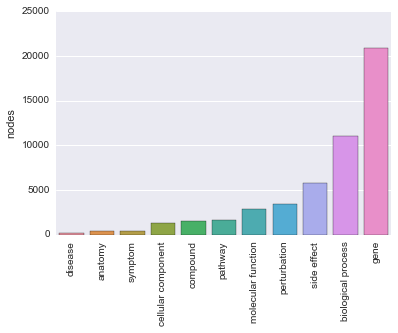

In [95]:
ax = seaborn.barplot(x='metanode', y='nodes', data=metanode_df.sort('nodes'))
for tick in ax.get_xticklabels():
    tick.set_rotation(90)
ax.set_xlabel(''); ax.set_ylabel('nodes');

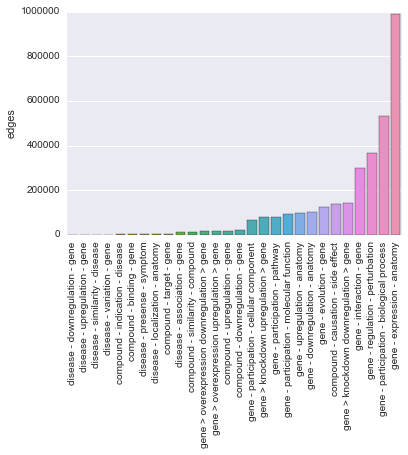

In [96]:
ax = seaborn.barplot(x='metaedge', y='edges', data=metaedge_df.sort('edges').query('inverted == 0'))
for tick in ax.get_xticklabels():
    tick.set_rotation(90)
ax.set_xlabel(''); ax.set_ylabel('edges');